# Test E & C Index calcs

In [1]:
import sys
sys.path.append('../')

#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.timePeriod as tp

In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import dask.config
dask.config.set({"array.slicing.split_large_chunks": True})

from dask.distributed import Client, LocalCluster
client = Client()
print(client)

In [5]:
#load the full model set
modelSet=_model.scenarioMip

This is the models which have alpha less than -0.15 from the Wang 2020

In [6]:
expectedToUse = modelSet[[4,9,11,12,15,17,30,29,22,31,32,33,21,6,7,35,36,20,8],:]
#expectedToUse = modelSet[[6,7],:]

In [7]:
expectedToUse

array([['CAMS', 'CAMS-CSM1-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['CMCC', 'CMCC-CM2-SR5', 'r1i1p1f1', 'r1i1p1f1'],
       ['CNRM-CERFACS', 'CNRM-CM6-1', 'r1i1p1f2_gn', 'r1i1p1f2_gn'],
       ['CNRM-CERFACS', 'CNRM-ESM2-1', 'r1i1p1f2_gn', 'r1i1p1f2_gn'],
       ['EC-Earth-Consortium', 'EC-Earth3', 'r1i1p1f1', 'r1i1p1f1'],
       ['EC-Earth-Consortium', 'EC-Earth3-Veg', 'r1i1p1f1', 'r1i1p1f1'],
       ['MIROC', 'MIROC6', 'r1i1p1f1', 'r1i1p1f1'],
       ['MIROC', 'MIROC-ES2L', 'r1i1p1f2_gn', 'r1i1p1f2_gn'],
       ['MOHC', 'HadGEM3-GC31-LL', 'r1i1p1f1', 'r1i1p1f3'],
       ['MPI-M', 'MPI-ESM1-2-HR', 'r1i1p1f1', 'r1i1p1f1'],
       ['MPI-M', 'MPI-ESM1-2-LR', 'r1i1p1f1', 'r1i1p1f1'],
       ['MRI', 'MRI-ESM2-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['NASA-GISS', 'GISS-E2-1-G', 'r1i1p1f2', 'r1i1p1f2'],
       ['NCAR', 'CESM2', 'r1i1p1f1', 'r10i1p1f1'],
       ['NCAR', 'CESM2-WACCM', 'r1i1p1f1', 'r1i1p1f1'],
       ['NCC', 'NorESM2-LM', 'r1i1p1f1', 'r1i1p1f1'],
       ['NCC', 'NorESM2-MM', 'r1i1p1f1

In [8]:
len(expectedToUse)

19

For all the models, calculate the alphas

ACCESS-CM2


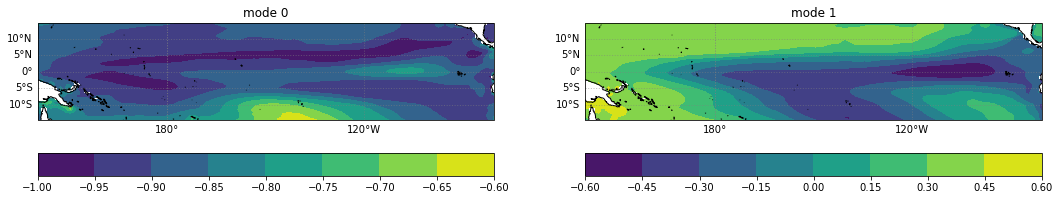

-0.0032564031775791026 ... 0.2339329978409129


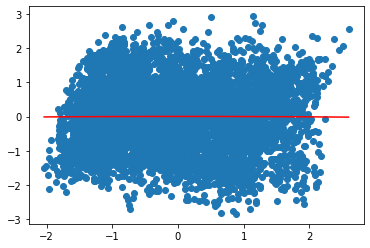

ACCESS-ESM1-5


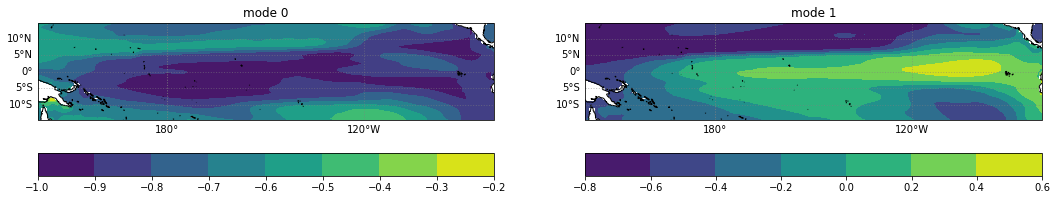

-0.11332341823775921 ... 0.15083683087641137


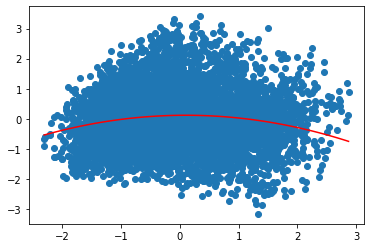

AWI-CM-1-1-MR


In [ ]:
%run ../utils/ecIndex.ipynb

alphas=list()
for iModel in modelSet:
    try:
        print(iModel[1])
        
        tsXr = xarray.concat([fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3], 
                                              ).tos, 
                              fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3], 
                                              ).tos], 
                             dim='time')

       
        sstAnomXr=sstAnoms(tsXr)

        sstAnomXr
        
        indeces, pFit, eofsXr = ecIndex(sstAnomXr)
        
        indeces
        
        indeces.to_netcdf('results/wangAlphas/index'+str(iModel[1])+'.nc')
        eofsXr.to_netcdf('results/wangAlphas/eof'+str(iModel[1])+'.nc')
        
        fig=plt.figure(figsize=(18,12))

        for mode in [0,1]:
            ax=fig.add_subplot(1,2,mode+1,
                           projection=ccrs.Miller(central_longitude=210))

            ensoPlotter(eofsXr.sel(mode=mode), ax)

            plt.title("mode " + str(mode))

        plt.show()

        print(str(indeces.alpha.values) + ' ... ' + str(indeces.alphaDjf.values))
        alphas.append(indeces.alpha.values)
        fig = plt.figure()

        plt.scatter(indeces.pc1, indeces.pc2)

        plt.plot(*pFit.linspace(), 'r')
        
        plt.show()
        
    except Exception as e:
        print(e)

In [ ]:
wangsAnswers=[-0.2902,-0.4055,-0.1662, -0.1687, -0.2662, -0.2665, -0.3198, -0.3466, -0.1785, -0.2660, 
             -0.2338, -0.3387, -0.3644, -0.3216, -0.2436, -0.2505, -.2077, -.1931, -.01886]

In [ ]:
print(alphas)

In [ ]:
len(alphas)

In [ ]:
array=numpy.array(alphas)

In [ ]:
array-wangsAnswers

In [ ]:
print('model         calculated           expected')
for i in range(0, len(expectedToUse)):
    iModel=expectedToUse[i,1]
    print(str(iModel) + ' : ' + str(alphas[i]) + '   ' + str(wangsAnswers[i]))

In [ ]:
alpha

# Full example /sandbox

Climatology and piControl:

In [ ]:
for iModel in [modelSet[29]]:
    
    print(iModel)
    
    try: 
            
        #to replicate Wang 2020
        tsXr = xarray.concat([fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3], 
                                               chunks={'time':120}).tos, 
                              fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3], 
                                               chunks={'time':120}).tos], 
                             dim='time')

        #tsXr = tsXr.where((tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
        #    drop=True)

        
    except Exception as e:
        print(iModel[1] + "Climatology did not calculate")
        print(e)
 

In [ ]:
(((tsXr.lon + 360) % 360))

In [ ]:
tsXr.lon

In [ ]:
tsXr.assign_coords({"lon": (((tsXr.lon + 180) % 360) - 180)})

In [ ]:
(tsXr.where(tsXr.lat==0).lon<0).any()

Cut it into the area of interest

In [ ]:
tsXr=tsXr.where(
    (tsXr.lat>=-15) & (tsXr.lat<=15) &
    (tsXr.lon>=140) & (tsXr.lon<=280),
    drop=True
)

In [ ]:
tsXr

In [ ]:
tsXr=tsXr.where(
    (tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
    drop=True
)


In [ ]:
tsXr 

In [ ]:
from eofs.xarray import Eof



In [ ]:
trendXr = tsXr.polyfit('time', 2)

In [ ]:
trendXr

In [ ]:
trendXr = xarray.polyval(tsXr.time, trendXr.polyfit_coefficients, 'degree')


In [ ]:
detrendXr=tsXr-trendXr

In [ ]:
detrendXr

In [ ]:
sstMeanXr=detrendXr.where((detrendXr.time.dt.year>=1900) * (detrendXr.time.dt.year<2000), 
            drop=True).groupby('time.month').mean(dim='time')

In [ ]:
sstMeanXr

In [ ]:
sstAnomXr=detrendXr.groupby('time.month')-sstMeanXr

In [ ]:
#sstAnomXr=sstAnomXr.drop('month')


trendXr.isel(x=0,y=0).plot()

detrendXr.isel(x=0,y=0).plot()

sstAnomXr.isel(x=0,y=0).plot()

In [ ]:
import cartopy.crs as ccrs


In [ ]:
#there seems to be a bug in the Eof solver that doesn't handle dask very well,so pre calculating the result makes it work
sstAnomXr.load()

In [ ]:
def myFunc(xr):

    #although they don't really say this, I've applied an area weighting.

    weights = numpy.cos(numpy.deg2rad(xr.lat)
                    ).values[..., numpy.newaxis]

    solver=Eof(xr) #, weights=weights)

    #each described by a principal spatial pattern and an associated
    #principal component (PC) time series.

    pcXr = solver.pcs(pcscaling=1, npcs=2)
   
    return pcXr

In [ ]:
#dcfAnomsXr=tp.averageForTimePeriod(sstAnomXr.rename('enso').to_dataset()).enso
#dcfAnomsXr=dcfAnomsXr.rename({'year':'time'})

In [ ]:
#dcfAnomsXr=sstAnomXr.where(
#    (sstAnomXr.time.dt.month==12)+(sstAnomXr.time.dt.month==1)+(sstAnomXr.time.dt.month==2), drop=True)

In [ ]:
pcTimeXr=myFunc(sstAnomXr)

In [ ]:
pcTimeXr

In [ ]:
def ensoPlotter(da, ax):
    cs=plt.contourf(da.lon, da.lat, da.values,  
                    transform=ccrs.PlateCarree(), 
                   center=True)

    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    ax.coastlines(color='black')
    gl.top_labels=False
    #gl.left_labels=False

        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)

In [ ]:
pcTimeXr.std('time')

In [ ]:
pcTimeXr.mean('time')

In [ ]:
dcfTimeXr=pcTimeXr.where((pcTimeXr.time.dt.month==12)+(
    pcTimeXr.time.dt.month==1)+(pcTimeXr.time.dt.month==2), drop=True)

In [ ]:
#pc1 = tp.averageForTimePeriod(pcTimeXr.sel(mode=0).rename('enso').to_dataset()).enso
#pc2 = tp.averageForTimePeriod(pcTimeXr.sel(mode=1).rename('enso').to_dataset()).enso

pc1 = dcfTimeXr.sel(mode=0)
pc2 = dcfTimeXr.sel(mode=1)

In [ ]:
pc1

In [ ]:
import numpy.polynomial as poly

In [ ]:
pFit = poly.Polynomial.fit(pc1, pc2, 2)



In [ ]:
pFit

In [ ]:
pFit.convert()

In [ ]:
alpha = pFit.convert().coef[2]

In [ ]:
alpha

In [ ]:
fig = plt.figure()

plt.scatter(pc1, pc2)

plt.plot(*pFit.linspace())

In [ ]:
cXr=(pc1+pc2)/numpy.sqrt(2)
eXr=(pc1-pc2)/numpy.sqrt(2)

In [ ]:
cXr.plot()

In [ ]:
fig = plt.figure()

plt.scatter(cXr.values, eXr.values)